# Get model to use as encoder and comparator

In [1]:

from torchvision.datasets import ImageFolder
from src.utils.config import RESNET34_FULL
from src.utils.config import BEETLE_DATASET, DEFAULT_TEST_PATH
from src.models import download_model, load_model_weights_and_metrics
import torchvision
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from src.GAM import GAM_fit
import numpy as np
import copy

In [2]:
dataset_config = BEETLE_DATASET
model_config = RESNET34_FULL

In [3]:
model = download_model(model_config, dataset_config)
_ = load_model_weights_and_metrics(model, model_config)

In [4]:
model = model.to('cuda:0')

# Data for Generator

In [5]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 448)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)])


In [6]:
gamset_sub = ImageFolder('./data/beetles/images_subset/', transform = transformer)
dataloader_sub = DataLoader(gamset_sub, batch_size = 16, num_workers = 12, shuffle=True)

In [7]:
gamset = ImageFolder(dataset_config['image_folder_path'], transform = transformer)
dataloader = DataLoader(gamset, batch_size = 16, num_workers = 12, shuffle=True)

# Discriminator and generator

In [8]:
def norm_img(img, mean, std):
    res = (img + 1) / 2
    return (res - mean) / std

In [9]:
def norm_latent(y):
    ret = y - torch.min(y)
    return ret / torch.max(ret)

def norm_latent_none(y):
    return y

In [10]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [11]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    D_block(in_channels=n_D*8, out_channels=n_D*16),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*16, out_channels=1,
              kernel_size=(7,14), bias=False))  # Output: (1, 1, 1)

In [12]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=(4,4), strides=(2,2),
                 padding=(1,1), **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [13]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=197, out_channels=n_G*16, kernel_size=(7,14),
            strides=1, padding=0),                  # Output: (64 * 16, 7, 14)
    G_block(in_channels=n_G*16, out_channels=n_G*8), # Output: (64 * 8, 14, 28)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 28, 56)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 56, 112)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 112, 224)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 224, 448)


for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)

# Testing

In [14]:
num_epochs = 40

In [15]:
def GAM_test_train(net_G, net_D, net_Cs, net_Es, norm_img, norm_latent, dataloader, lambdas_list, num_epochs, names):
    # net_G = net
    # net_D = net
    # net_Cs = [net]
    # net_Es = [net, None]
    # norm_img = func
    # norm_latent = func
    # dataloader = dataloader
    # lambdas_list = [lambdas]
    # num_epochs = int
    for i in range(len(lambdas_list)):
        for w in net_D.parameters():
            nn.init.normal_(w, 0, 0.02)
        for w in net_G.parameters():
            nn.init.normal_(w, 0, 0.02)
        gen, stats = GAM_fit(net_G, net_D, net_Cs[i], norm_img, norm_latent, dataloader, lambdas = lambdas_list[i], num_epochs=num_epochs, enc = net_Es[i], lrs = [0.002, 0.9, 0.999])
        torch.save(gen.state_dict(), DEFAULT_TEST_PATH + names[i] + '_gen.pt')
        np.save(DEFAULT_TEST_PATH + names[i] + '_stats.npy', np.array(stats))


## latent code vs one-hot

In [16]:
net_Cs = [model]*2
net_Es = [model, None]
lambdas_list = [np.array([100, 2e-6, 0.01])]*2
names = ['latent_code', 'one_hot_code']

#GAM_test_train(net_G, net_D, net_Cs, net_Es, norm_img, norm_latent_none, dataloader_sub, lambdas_list, num_epochs, names)

## Lambda values

0.29628915311617393
168.7742800174014
20.927325607867363
1.7852350574510558
191.48683670225387


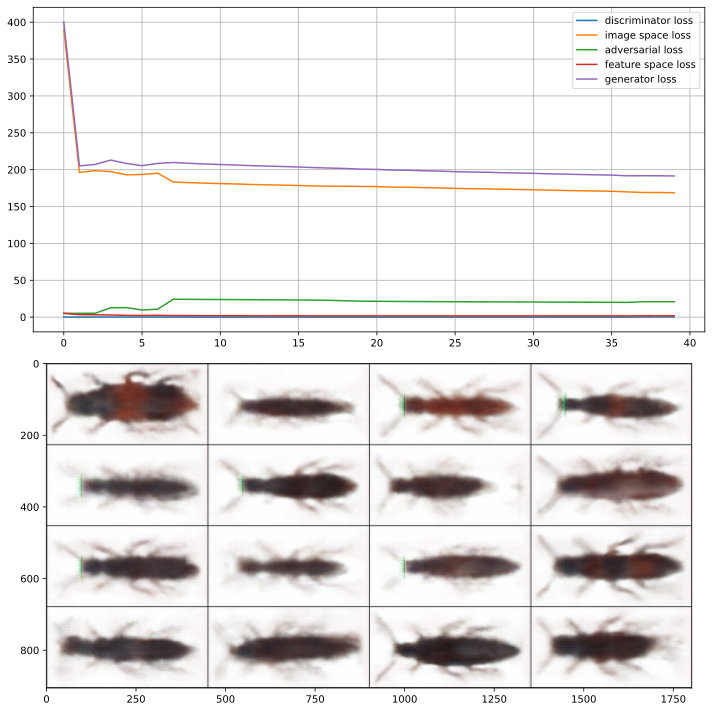

Training complete in 137m 7s


In [17]:
net_Cs = [model]
net_Es = [model]
lambdas_list = [np.array([2,1/2000, 1/100])]
names = ['test']
GAM_test_train(net_G, net_D, net_Cs, net_Es, norm_img, norm_latent_none, dataloader_sub, lambdas_list, num_epochs, names)

In [18]:
lambdas_equal = np.array([2,1/20000, 1/100])
lambdas_feat = np.array([2,1/20000, 3/100])
lambdas_adv = np.array([6,1/20000, 1/100])
lambdas_img = np.array([2,3/20000, 1/100])

In [19]:
net_Cs = [model]
net_Es = [model]
lambdas_list = [lambdas_img]
names = ['lambdas_img']
#GAM_test_train(net_G, net_D, net_Cs, net_Es, norm_img, norm_latent_none, dataloader_sub, lambdas_list, num_epochs, names)

0.259500183865186
3.768719432744073
5.3361934629504475
4.245205838293044
13.350118530736998


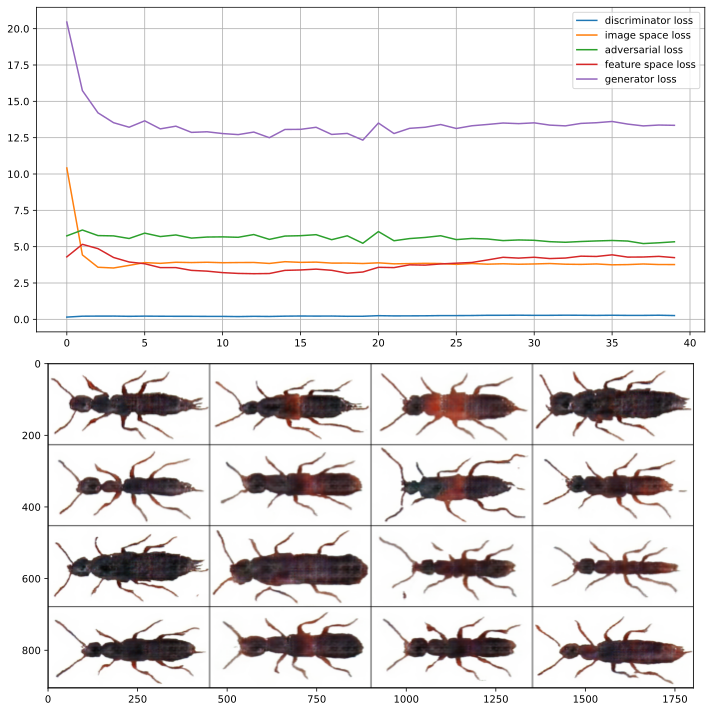

Training complete in 146m 29s


In [20]:
net_Cs = [model]
net_Es = [model]
lambdas_list = [lambdas_equal]
names = ['lambdas_equal']
#GAM_test_train(net_G, net_D, net_Cs, net_Es, norm_img, norm_latent_none, dataloader_sub, lambdas_list, num_epochs, names)

0.17946008114663348
4.098188747255542
6.145111729954899
6.852488845588505
17.095789070956393


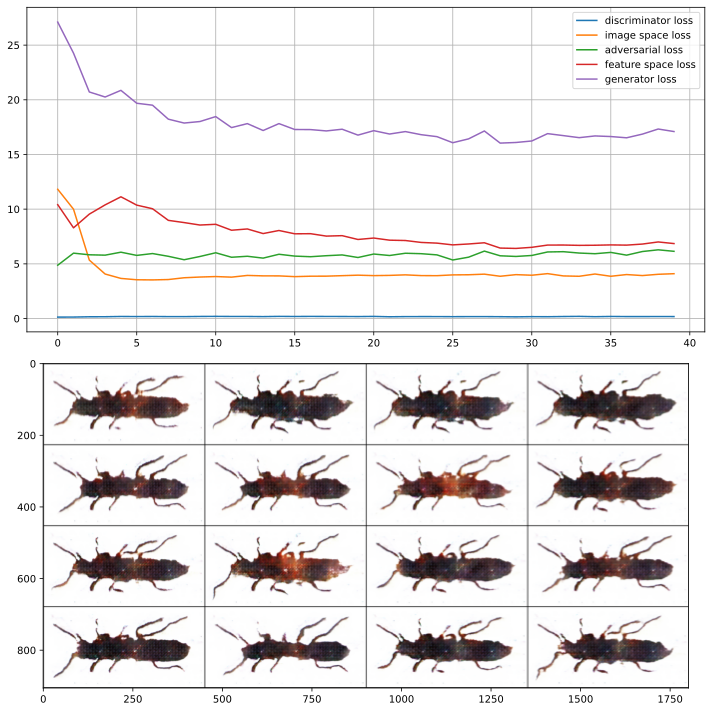

Training complete in 141m 26s


In [21]:
net_Cs = [model]
net_Es = [model]
lambdas_list = [lambdas_feat]
names = ['lambdas_feat']
#GAM_test_train(net_G, net_D, net_Cs, net_Es, norm_img, norm_latent_none, dataloader_sub, lambdas_list, num_epochs, names)

In [22]:
net_Cs = [model]
net_Es = [model]
lambdas_list = [lambdas_adv]
names = ['lambdas_adv']
GAM_test_train(net_G, net_D, net_Cs, net_Es, norm_img, norm_latent_none, dataloader_sub, lambdas_list, num_epochs, names)

## Test comparitor structure

In [23]:
model1 = copy.deepcopy(model)
model2 = copy.deepcopy(model)

In [24]:
# truncate the model
import types
def _new_forward_impl(self, x: torch.Tensor) -> torch.Tensor:
    # See note [TorchScript super()]
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    return x
model1._forward_impl = types.MethodType(_new_forward_impl, model1)

In [25]:
# truncate the model
import types
def _new_forward_impl(self, x: torch.Tensor) -> torch.Tensor:
    # See note [TorchScript super()]
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    return x
model2._forward_impl = types.MethodType(_new_forward_impl, model2)


In [26]:
net_Cs = [model1, model2]
net_Es = [model]*2
lambdas_list = [np.array([100, 2e-6, 0.01])]*2
names = ['comp_maxpool', 'comp_layer3']

#GAM_test_train(net_G, net_D, net_Cs, net_Es, norm_img, norm_latent_none, dataloader_sub, lambdas_list, num_epochs, names)

# Apply the damn thing!!!!!!!!!

In [27]:
#gen = GAM_fit(net_G, net_D, model, norm_img, norm_latent, dataloader_sub, num_epochs=100)

In [28]:
#torch.save(gen.state_dict(), 'Gen_02.pt' )